# De los laberintos se sale por arriba

Una parte importante de este trabajo consiste en confiar que el esquema de inferencia bayesiano funciona bien.
Entonces uno se pregunta: ¿qué quiere decir 'funciona bien'?

La manera usual de analizar si el esquema de inversión de parámetros es confiable se basa en darle una
entrada 'hecha a mano', aplicar el algoritmo de inferencia y analizar si a la salida hay lo mismo que 
pusimos a la entrada. Eso suele llamarse algo así como 'sanidad del modelo'.

### A los bifes:

Nuestra entrada hecha a mano va a representar el scattering deibo a un medio rugoso estratificado que recibe la antena UWB.
A la antena la representamos con *Scal*, la señal que recibe la antena luego de la reflexión ante un conductor ideal.
Para simular al medio rugoso estratificado multiplicamos a *Scal* por el coeficiente de reflexión de modelo de Pinel.

Entonces, nuetra señal de entrada será:

\begin{equation}
 S_{sim} = S_{cal}\,R_{rug}(\epsilon_1,\epsilon_2,d,s_0,s_1,f),
\end{equation}

o sea, vamos a simular un medio estratificado con dos superficies rugosas, la primera (con rugosidad $s_0$ y ubicada en $z=0$) separa al aire de la primera capa ($\epsilon_1$), la segunda (con rugosidad $s_1$ y ubicada en $z=-d$) separa a la primera capa de la segunda (que tiene cte. dieléctrica $\epsilon_2$). Las frecuencias $f$ será, obviamente, la obtenida de la FFT de la señal *Scal*.

En un mundo ideal, en donde la medición no tiene ninguna incerteza (noise_level = 0), **si el esquema de inferencia está bien definido**, los parámetros de entrada deben ser iguales a los parámetros óptimos de la salida.

Lo que vamos a simular es lo siguiente:

- generamos *S_sim* con la señal target de julio y usando parámetros $\{\epsilon_1, \epsilon_2, d, s_0, s_1 \}$ elegidos a mano;
- metemos esta señal en el esquema bayesiano en donde además decimos que el ruido es cero;
- vemos qué hay a la salida.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
sns.set()
import pandas as pd

import theano.tensor as TT
import time
import random

import pymc3 as pm
import arviz as az

import sys
from scipy import stats as st

%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb
%run /home/tele/Desktop/UWB/codigos_auxiliares/Pinel.ipynb
%run /home/tele/Desktop/UWB/codigos_auxiliares/R_Fresnel.ipynb

### Señal target simulada

In [2]:
Scal = np.load('Scal.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
fpos = np.load('fpos.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

print('dim Scal:',np.shape(Scal)[0])
print('dim fpos:',np.shape(fpos)[0])

dim Scal: 380
dim fpos: 380


### genero una señal sintética para ver luego si el esquema bayesiano lograr recuperar los parámetros de entrada


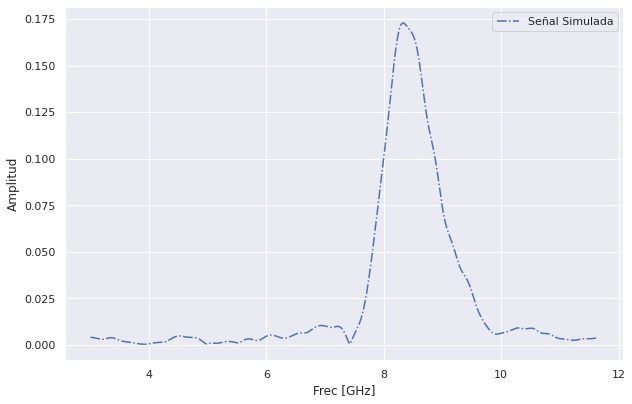

In [3]:
ep1_in = 10 + 1j*3
ep2_in = 18 + 1j*4.5
d_in = 0.085
s0_in = 3e-3
s1_in = 8.5e-4

inputs_par = np.asarray([ep1_in, ep2_in, d_in, s0_in, s1_in])

S_sim = Scal*R_pinel_2L(ep1_in,ep2_in,d_in,s0_in,s1_in,fpos)

plt.figure(figsize=(10,6.5))
plt.plot(fpos/1e9,np.abs(S_sim),'-.',label = 'Señal Simulada')
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.legend(loc = 'best')
plt.show()

### Hago la inferencia bayesiana usando ruido cero

- Solo le voy a pedir que infiera la parte real de las ctes dieléctricas, las rugosidades y el ancho de la capa.
- Enotnces, el el código Bayes2 puse a mano la parte imaginaria de las ctes dieléctricas

In [11]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 8000
noise_level = 0.001*np.max(np.abs(S_sim))

# error de la medición
sigmas = noise_level*np.ones((1,len(S_sim)))

# un solo medio dieléctrico
NLayers = 2


# inferencia bayesiana
traza_2L_rug = modelo(S_sim,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido usando Inf. Bayesiana y 2 layers: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other param

Tiempo insumido usando Inf. Bayesiana y 2 layers: 267.2 seg (4.45 min)


In [12]:
# Traza_2L_rug = pm.save_trace(traza_2L_rug)

# pm.load_trace(traza_2L_rug)

In [13]:
traza_2L_rug.varnames

['ep1_r_interval__',
 'ep2_r_interval__',
 'd_interval__',
 's0_interval__',
 's1_interval__',
 'ep1_r',
 'ep2_r',
 'd',
 's0',
 's1',
 'S2_teo']

In [14]:
name_list = traza_2L_rug.varnames[5:10]

Modas = []
VMedios = []
Std = []

for name in name_list:
    moda = round(st.mode(traza_2L_rug[name])[0][0],5)
    v_medio = round(np.mean(traza_2L_rug[name]),5)
    std = round(np.std(traza_2L_rug[name]),5)
    
    Modas.append(moda)
    VMedios.append(v_medio)
    Std.append(std)
    
print('Modas: ', Modas)
print('V. Medios :', VMedios)
print('Std :', Std)

Modas:  [10.01604, 18.76439, 0.08481, 0.00306, 0.00086]
V. Medios : [10.00184, 18.1501, 0.08487, 0.003, 0.00085]
Std : [0.06861, 0.64451, 0.00029, 8e-05, 2e-05]


In [15]:
Correlaciones = []

for j0 in range(len(name_list)):
    for j1 in range(len(name_list)):
        
        if(j0<j1):
        
            corr = round(np.corrcoef(traza_2L_rug[name_list[j0]],traza_2L_rug[name_list[j1]])[0,1],3)
            # print(corr)
            Correlaciones.append(corr)

print(Correlaciones)

[0.285, -1.0, -0.481, 0.996, -0.274, 0.694, 0.284, 0.491, -0.996, -0.482]


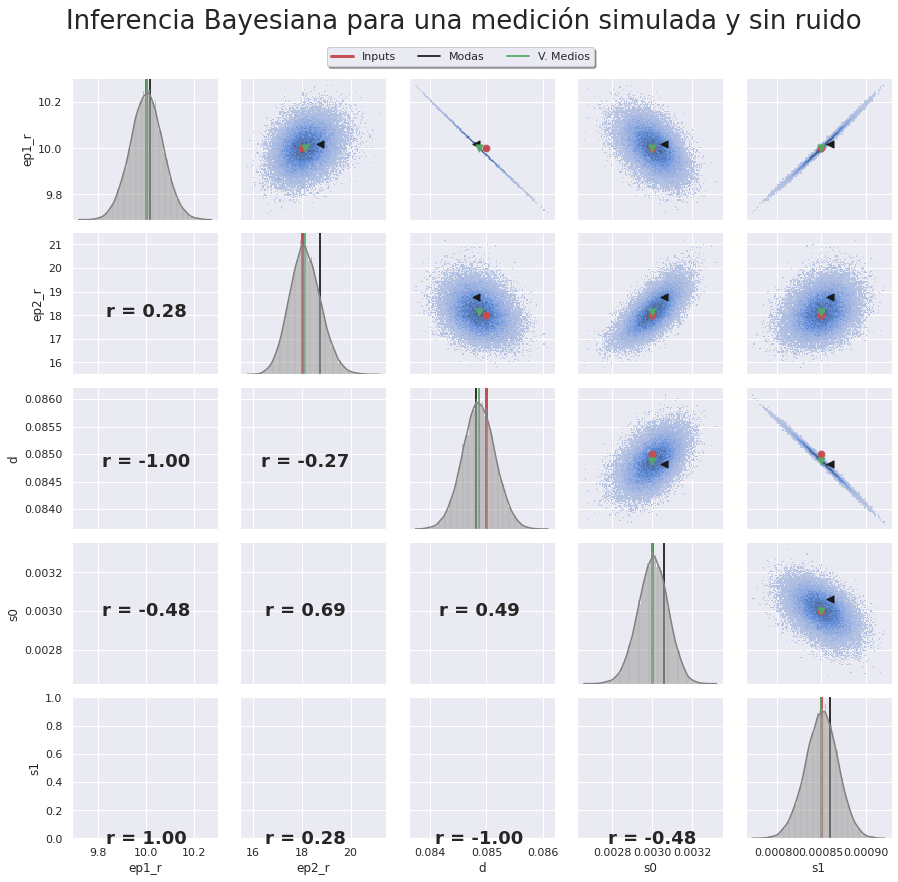

In [49]:


plotear = np.stack((traza_2L_rug['ep1_r'], traza_2L_rug['ep2_r'], traza_2L_rug['d'],traza_2L_rug['s0'],traza_2L_rug['s1'])).T 
dfplotear = pd.DataFrame(plotear, columns = name_list)

g = sns.PairGrid(dfplotear)
g.map_upper(sns.histplot)
g.map_diag(sns.histplot, kde=True, color='.5')
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Inferencia Bayesiana para una medición simulada y sin ruido', fontsize = 26)

for j in range(len(name_list)):
    l1 = g.axes[j,j].axvline(np.real(inputs_par[j]), color='r', linestyle='solid', linewidth=3, label = 'Input')
    l2 = g.axes[j,j].axvline(Modas[j], color='k', linestyle='solid', linewidth=1.75, label = 'Moda')
    l3 = g.axes[j,j].axvline(VMedios[j], color='g', linestyle='solid', linewidth=1.75, label = 'V. Medio')

ind_corr = 0
for j0 in range(len(name_list)):
    for j1 in range(len(name_list)):
        
        if(j1>j0):
            g.axes[j0,j1].scatter(np.real(inputs_par[j1]), np.real(inputs_par[j0]), marker="8", c='r', s=50)
            g.axes[j0,j1].scatter(Modas[j1], Modas[j0], marker="<", c='k', s=50)
            g.axes[j0,j1].scatter(VMedios[j1], VMedios[j0], marker="v", c='g', s=50)
            
            g.axes[j1,j0].annotate("r = {:.2f}".format(Correlaciones[ind_corr]),  xy=(VMedios[j0],VMedios[j1]), weight='bold', 
                                 ha='center', va='center', size=18)
            ind_corr = ind_corr + 1

plt.legend([l1,l2,l3],['Inputs','Modas','V. Medios'],bbox_to_anchor=(-1, 5.65), shadow=True, ncol = 3)
plt.savefig('/home/tele/Desktop/sim1.jpg', dpi = 400)


In [32]:
for j in range(len(name_list)):
    print(name_list[j])
    print('input :', np.real(inputs_par[j]))
    print('output :', str(VMedios[j])+"\u00B1"+str(Std[j]))
    print()
    print('------------')
    print()


ep1_r
input : 10.0
output : 10.00184±0.06861

------------

ep2_r
input : 18.0
output : 18.1501±0.64451

------------

d
input : 0.085
output : 0.08487±0.00029

------------

s0
input : 0.003
output : 0.003±8e-05

------------

s1
input : 0.00085
output : 0.00085±2e-05

------------



### Este gráfico es la definición de perfección. Las marginales para cada parámetro son gaussianas angostas --> casi deltas de Dirac (este caso sería obtener los parámetros de salida sin error). Los valores medios coinciden con los valores de entrada y las desviaciones estándar son todas dos o tres órdenes de magnitud que cada valor medio. O sea, anda joya.

### En este caso es directo ver que los valores medios de cada distribución marginal son los valores óptimos del ajuste. Pero pueden no serlo, entonces uno se pregunta (o debería preguntarse) cómo obtener tales valores.


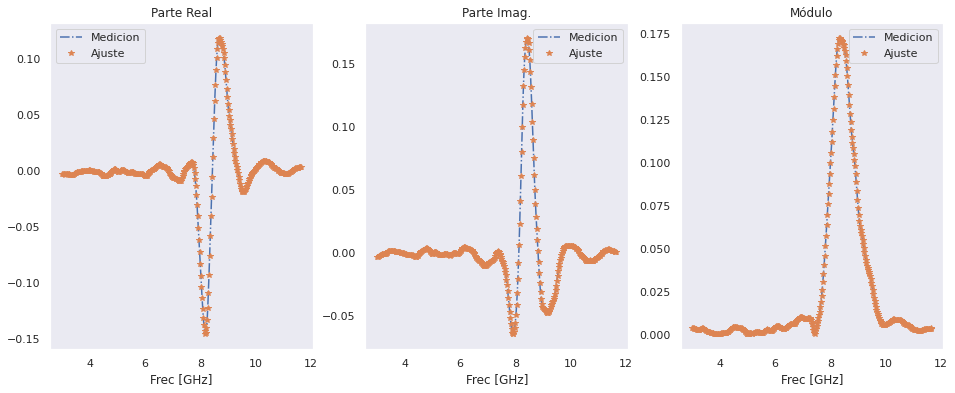

Error RMS =  7.5e-05
Energía S_sim =  0.215408
Energía S_fit =  0.215415


In [33]:
EP1 = VMedios[0] + 1j*np.imag(ep1_in)
EP2 = VMedios[1] + 1j*np.imag(ep2_in)
Dist = VMedios[2]
S0_opt = VMedios[3]
S1_opt = VMedios[4]

S_fit = Scal*R_pinel_2L(EP1,EP2,Dist,S0_opt,S1_opt,fpos) # señal 'medida'


fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(fpos/1e9,np.real(S_sim),'-.',label="Medicion")
ax[0].plot(fpos/1e9,np.real(S_fit),'*',label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(fpos/1e9,np.imag(S_sim),'-.',label="Medicion")
ax[1].plot(fpos/1e9,np.imag(S_fit),'*',label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(fpos/1e9,np.abs(S_sim),'-.',label="Medicion")
ax[2].plot(fpos/1e9,np.abs(S_fit),'*',label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()



e_RMS = np.sum(np.abs(np.abs(S_sim)-np.abs(S_fit)))/len(S_sim)

## calculo las energías:

E_sim = np.trapz(np.abs(S_sim),fpos/1e9)
E_fit = np.trapz(np.abs(S_fit),fpos/1e9)

print('Error RMS = ', round(e_RMS,6))
print('Energía S_sim = ', round(E_sim,6))
print('Energía S_fit = ', round(E_fit,6))

O sea, el ajuste es perfecto! 

In [90]:
# plt.figure(figsize=(12,8))
# az.plot_forest(traza_2L_rug['ep2_r'])
# az.plot_trace(traza_2L_rug['ep2_r'])
# plt.show()

### Metamos ruido a la inferencia, a ver qué pasa.

In [34]:
t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 7500
noise_level = 0.01*np.max(np.abs(S_sim)) # nivel de ruido = 1% del máximo valor medido

# error de la medición
sigmas = noise_level*np.ones((1,len(S_sim)))

# un solo medio dieléctrico
NLayers = 2


# inferencia bayesiana
traza_2L_rug_ruido = modelo(S_sim,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido usando Inf. Bayesiana y 2 layers: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other param

Tiempo insumido usando Inf. Bayesiana y 2 layers: 195.98 seg (3.27 min)


In [35]:
Modas_2 = []
VMedios_2 = []
Std_2 = []

for name in name_list:
    moda = round(st.mode(traza_2L_rug_ruido[name])[0][0],5)
    v_medio = round(np.mean(traza_2L_rug_ruido[name]),5)
    std = round(np.std(traza_2L_rug_ruido[name]),5)
    
    Modas_2.append(moda)
    VMedios_2.append(v_medio)
    Std_2.append(std)
    

Correlaciones_2 = []

for j0 in range(len(name_list)):
    for j1 in range(len(name_list)):
        
        if(j0<j1):
        
            corr = round(np.corrcoef(traza_2L_rug_ruido[name_list[j0]],traza_2L_rug_ruido[name_list[j1]])[0,1],3)
            # print(corr)
            Correlaciones_2.append(corr)

    
print('Inputs: ', np.real(inputs_par))
print('Modas: ', Modas_2)
print('V. Medios :', VMedios_2)
print('Std :', Std_2)
print('Corr :', Correlaciones_2)

Inputs:  [1.0e+01 1.8e+01 8.5e-02 3.0e-03 8.5e-04]
Modas:  [10.56007, 18.17505, 0.08257, 0.00256, 0.00099]
V. Medios : [9.85302, 18.61718, 0.08563, 0.00314, 0.00078]
Std : [0.619, 2.33024, 0.00266, 0.00054, 0.0002]
Corr : [0.135, -0.997, -0.889, 0.966, -0.126, 0.294, 0.12, 0.89, -0.978, -0.868]


ep1_r
input : 10.0
output : 9.85302±0.619

------------

ep2_r
input : 18.0
output : 18.61718±2.33024

------------

d
input : 0.085
output : 0.08563±0.00266

------------

s0
input : 0.003
output : 0.00314±0.00054

------------

s1
input : 0.00085
output : 0.00078±0.0002

------------



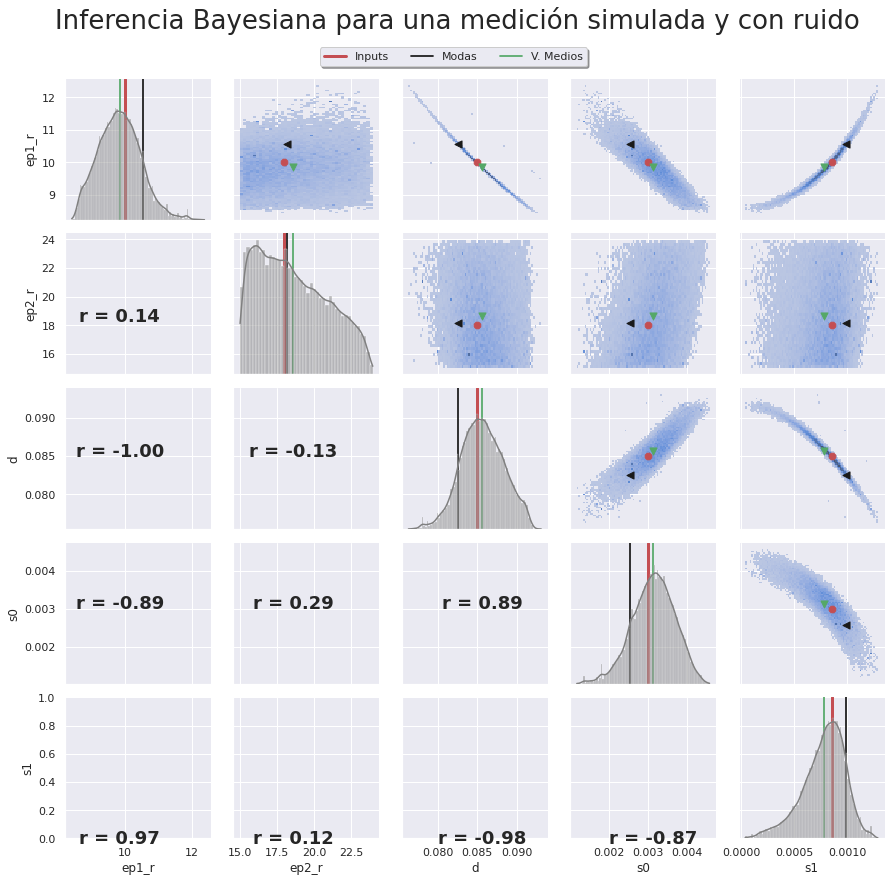

In [48]:
plotear_2 = np.stack((traza_2L_rug_ruido['ep1_r'], traza_2L_rug_ruido['ep2_r'], traza_2L_rug_ruido['d'],
                    traza_2L_rug_ruido['s0'],traza_2L_rug_ruido['s1'])).T 
dfplotear_2 = pd.DataFrame(plotear_2, columns = name_list)

g = sns.PairGrid(dfplotear_2)
g.map_upper(sns.histplot)
g.map_diag(sns.histplot, kde=True, color='.5')
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Inferencia Bayesiana para una medición simulada y con ruido', fontsize = 26)

for j in range(len(name_list)):
    l1 = g.axes[j,j].axvline(np.real(inputs_par[j]), color='r', linestyle='solid', linewidth=3)
    l2 = g.axes[j,j].axvline(Modas_2[j], color='k', linestyle='solid', linewidth=1.75)
    l3 = g.axes[j,j].axvline(VMedios_2[j], color='g', linestyle='solid', linewidth=1.75)
    
ind_corr = 0
for j0 in range(len(name_list)):
    for j1 in range(len(name_list)):
        
        if(j1>j0):
            g.axes[j0,j1].scatter(np.real(inputs_par[j1]), np.real(inputs_par[j0]), marker="8", c='r', s=50)
            g.axes[j0,j1].scatter(Modas_2[j1], Modas_2[j0], marker="<", c='k', s=50)
            g.axes[j0,j1].scatter(VMedios_2[j1], VMedios_2[j0], marker="v", c='g', s=50)
            
            g.axes[j1,j0].annotate("r = {:.2f}".format(Correlaciones_2[ind_corr]),  xy=(VMedios_2[j0],VMedios_2[j1]), weight='bold', 
                                 ha='center', va='center', size=18)
            ind_corr = ind_corr + 1


plt.legend([l1,l2,l3],['Inputs','Modas','V. Medios'],bbox_to_anchor=(-1, 5.65), shadow=True, ncol = 3)
plt.savefig('/home/tele/Desktop/sim2.jpg', dpi = 400)

for j in range(len(name_list)):
    print(name_list[j])
    print('input :', np.real(inputs_par[j]))
    print('output :', str(VMedios_2[j])+"\u00B1"+str(Std_2[j]))
    print()
    print('------------')
    print()

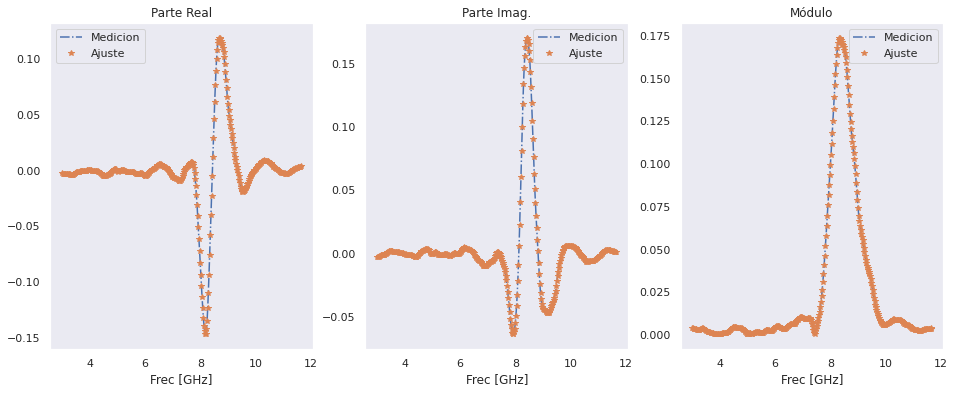

Error del ajuste (sin ruido) =  7.5e-05
Error del ajuste (con ruido) =  8.4e-05

Energía S_sim =  0.215408
Energía S_fit (sin ruido) :  0.215415
Energía S_fit (con ruido) :  0.216031


In [50]:
EP1_opt2 = VMedios_2[0] + 1j*np.imag(ep1_in)
EP2_opt2= VMedios_2[1] + 1j*np.imag(ep2_in)
D_opt2 = VMedios_2[2]
S0_opt2 = VMedios_2[3]
S1_opt2 = VMedios_2[4]

S_fit2 = Scal*R_pinel_2L(EP1_opt2,EP2_opt2,D_opt2,S0_opt2,S1_opt2,fpos) # señal 'medida'


fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(fpos/1e9,np.real(S_sim),'-.',label="Medicion")
ax[0].plot(fpos/1e9,np.real(S_fit2),'*',label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(fpos/1e9,np.imag(S_sim),'-.',label="Medicion")
ax[1].plot(fpos/1e9,np.imag(S_fit2),'*',label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(fpos/1e9,np.abs(S_sim),'-.',label="Medicion")
ax[2].plot(fpos/1e9,np.abs(S_fit2),'*',label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()



e_MAE2 = np.sum(np.abs(np.abs(S_sim)-np.abs(S_fit2)))/len(S_sim)

## calculo las energías:

E_sim = np.trapz(np.abs(S_sim),fpos/1e9)
E_fit2 = np.trapz(np.abs(S_fit2),fpos/1e9)

print('Error del ajuste (sin ruido) = ', round(e_RMS,6))
print('Error del ajuste (con ruido) = ', round(e_MAE2,6))
print()
print('Energía S_sim = ', round(E_sim,6))
print('Energía S_fit (sin ruido) : ', round(E_fit,6))
print('Energía S_fit (con ruido) : ', round(E_fit2,6))

Se ve que con este nivel de ruido la inferencia sigue siendo muy buena. Uno puede seguir aumentando el nivel de ruido para ver cuándo el algoritmo se degrada y la inversión de parámetros deja de ser confiable. La diferencia de energías es menor al 1%.

### Ajusto la señal simulada con el modelo de dos capas pero sin rugosidad

In [51]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 7500
noise_level = 0.001*np.max(np.abs(S_sim)) # nivel de ruido = 1% del máximo valor medido

# error de la medición
sigmas = noise_level*np.ones((1,len(S_sim)))

# un solo medio dieléctrico
NLayers = 2


# inferencia bayesiana
traza_2L_plano = modelo(S_sim,muestras,sigmas,NLayers,False)

t1 = time.time()
print('Tiempo insumido usando Inf. Bayesiana y 2 layers: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other param

Tiempo insumido usando Inf. Bayesiana y 2 layers: 94.27 seg (1.57 min)


In [52]:
traza_2L_plano.varnames

['ep1_r_interval__',
 'ep2_r_interval__',
 'd_interval__',
 'ep1_r',
 'ep2_r',
 'd',
 'S2_teo']

In [53]:
name_list2 = traza_2L_plano.varnames[3:6]

name_list2

['ep1_r', 'ep2_r', 'd']

In [54]:
Modas_3 = []
VMedios_3 = []
Std_3 = []

for name in name_list2:
    moda = round(st.mode(traza_2L_plano[name])[0][0],5)
    v_medio = round(np.mean(traza_2L_plano[name]),5)
    std = round(np.std(traza_2L_plano[name]),5)
    
    Modas_3.append(moda)
    VMedios_3.append(v_medio)
    Std_3.append(std)
    

Correlaciones_3 = []

for j0 in range(len(name_list2)):
    for j1 in range(len(name_list2)):
        
        if(j0<j1):
        
            corr = round(np.corrcoef(traza_2L_plano[name_list[j0]],traza_2L_plano[name_list[j1]])[0,1],3)
            # print(corr)
            Correlaciones_3.append(corr)

    
print('Inputs: ', np.real(inputs_par))
print('Modas: ', Modas_3)
print('V. Medios :', VMedios_3)
print('Std :', Std_3)
print('Corr :', Correlaciones_3)

Inputs:  [1.0e+01 1.8e+01 8.5e-02 3.0e-03 8.5e-04]
Modas:  [8.50381, 24.99592, 0.02492]
V. Medios : [8.49284, 24.76452, 0.0249]
Std : [0.00534, 0.22152, 5e-05]
Corr : [-0.115, 0.285, 0.003]


ep1_r
input : 10.0
output : 8.49284±0.00534

------------

ep2_r
input : 18.0
output : 24.76452±0.22152

------------

d
input : 0.085
output : 0.0249±5e-05

------------



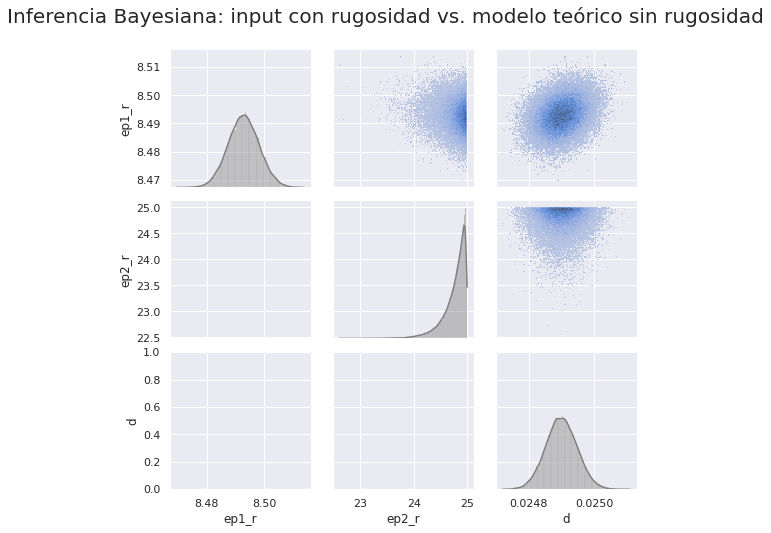

In [56]:
plotear_3 = np.stack((traza_2L_plano['ep1_r'], traza_2L_plano['ep2_r'], traza_2L_plano['d'])).T 
dfplotear_3 = pd.DataFrame(plotear_3, columns = name_list2)

g = sns.PairGrid(dfplotear_3)
g.map_upper(sns.histplot)
g.map_diag(sns.histplot, kde=True, color='.5')
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Inferencia Bayesiana: input con rugosidad vs. modelo teórico sin rugosidad', fontsize = 20)
plt.savefig('/home/tele/Desktop/sim3.jpg', dpi = 400)
# for j in range(len(name_list2)):
#     # g.axes[j,j].axvline(np.real(inputs_par[j]), color='r', linestyle='solid', linewidth=0.75)
#     g.axes[j,j].axvline(Modas_2[j], color='k', linestyle='solid', linewidth=1.75)
#     g.axes[j,j].axvline(VMedios_2[j], color='g', linestyle='solid', linewidth=1.75)
    
# ind_corr = 0
# for j0 in range(len(name_list2)):
#     for j1 in range(len(name_list2)):
        
#         if(j1>j0):
#             g.axes[j0,j1].scatter(np.real(inputs_par[j1]), np.real(inputs_par[j0]), marker="8", c='k', s=50)
#             # g.axes[j0,j1].scatter(Modas_2[j1], Modas_2[j0], marker="v", c='r', s=50)
#             g.axes[j0,j1].scatter(VMedios_3[j1], VMedios_3[j0], marker="v", c='r', s=50)
            
#             g.axes[j1,j0].annotate("r = {:.2f}".format(Correlaciones_3[ind_corr]),  xy=(VMedios_3[j0],VMedios_3[j1]), weight='bold', 
#                                  ha='center', va='center', size=18)
#             ind_corr = ind_corr + 1



for j in range(len(name_list2)):
    print(name_list2[j])
    print('input :', np.real(inputs_par[j]))
    print('output :', str(VMedios_3[j])+"\u00B1"+str(Std_3[j]))
    print()
    print('------------')
    print()

### Fulero fulero. Lo cual, creo, que era de esperarse.

### Ajuste de la señal simulada con modelo rugoso de tres capas

In [57]:
%run /home/tele/Desktop/UWB/codigos_auxiliares/Bayes2.ipynb

t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 7500
noise_level = 0.001*np.max(np.abs(S_sim))

# error de la medición
sigmas = noise_level*np.ones((1,len(S_sim)))

# un solo medio dieléctrico
NLayers = 3


# inferencia bayesiana
traza_sim_3L_rug = modelo(S_sim,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido usando Inf. Bayesiana y 3 layers: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/tele/anaconda3/envs/prosat/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other param

Tiempo insumido usando Inf. Bayesiana y 3 layers: 580.74 seg (9.68 min)


In [58]:
traza_sim_3L_rug.varnames

['ep1_r_interval__',
 'ep2_r_interval__',
 'ep3_r_interval__',
 'd1_interval__',
 'd2_interval__',
 's0_interval__',
 's1_interval__',
 's2_interval__',
 'ep1_r',
 'ep2_r',
 'ep3_r',
 'd1',
 'd2',
 's0',
 's1',
 's2',
 'S2_teo']

In [59]:
name_list3 = traza_sim_3L_rug.varnames[8:16]

name_list3

['ep1_r', 'ep2_r', 'ep3_r', 'd1', 'd2', 's0', 's1', 's2']

In [60]:
Modas_4 = []
VMedios_4 = []
Std_4 = []

for name in name_list3:
    moda = round(st.mode(traza_sim_3L_rug[name])[0][0],5)
    v_medio = round(np.mean(traza_sim_3L_rug[name]),5)
    std = round(np.std(traza_sim_3L_rug[name]),5)
    
    Modas_4.append(moda)
    VMedios_4.append(v_medio)
    Std_4.append(std)
    

Correlaciones_4 = []

for j0 in range(len(name_list3)):
    for j1 in range(len(name_list3)):
        
        if(j0<j1):
        
            corr = round(np.corrcoef(traza_sim_3L_rug[name_list3[j0]],traza_sim_3L_rug[name_list3[j1]])[0,1],3)
            # print(corr)
            Correlaciones_4.append(corr)

    
print('Inputs: ', np.real(inputs_par))
print('Modas: ', Modas_4)
print('V. Medios :', VMedios_4)
print('Std :', Std_4)
print('Corr :', Correlaciones_4)



Inputs:  [1.0e+01 1.8e+01 8.5e-02 3.0e-03 8.5e-04]
Modas:  [14.96316, 26.98161, 27.5042, 0.06955, 0.10136, 0.00158, 0.00109, 0.0005]
V. Medios : [14.92301, 26.97171, 27.50603, 0.06966, 0.10135, 0.00157, 0.0011, 0.0005]
Std : [0.02459, 0.01977, 0.07126, 6e-05, 0.00014, 0.0, 1e-05, 0.0]
Corr : [0.657, 0.173, -0.967, -0.512, 0.893, -0.626, 0.363, 0.237, -0.616, -0.459, 0.571, -0.374, 0.542, -0.161, -0.169, 0.152, -0.093, 0.127, 0.308, -0.88, 0.527, -0.337, -0.391, 0.628, -0.269, -0.56, 0.314, -0.226]


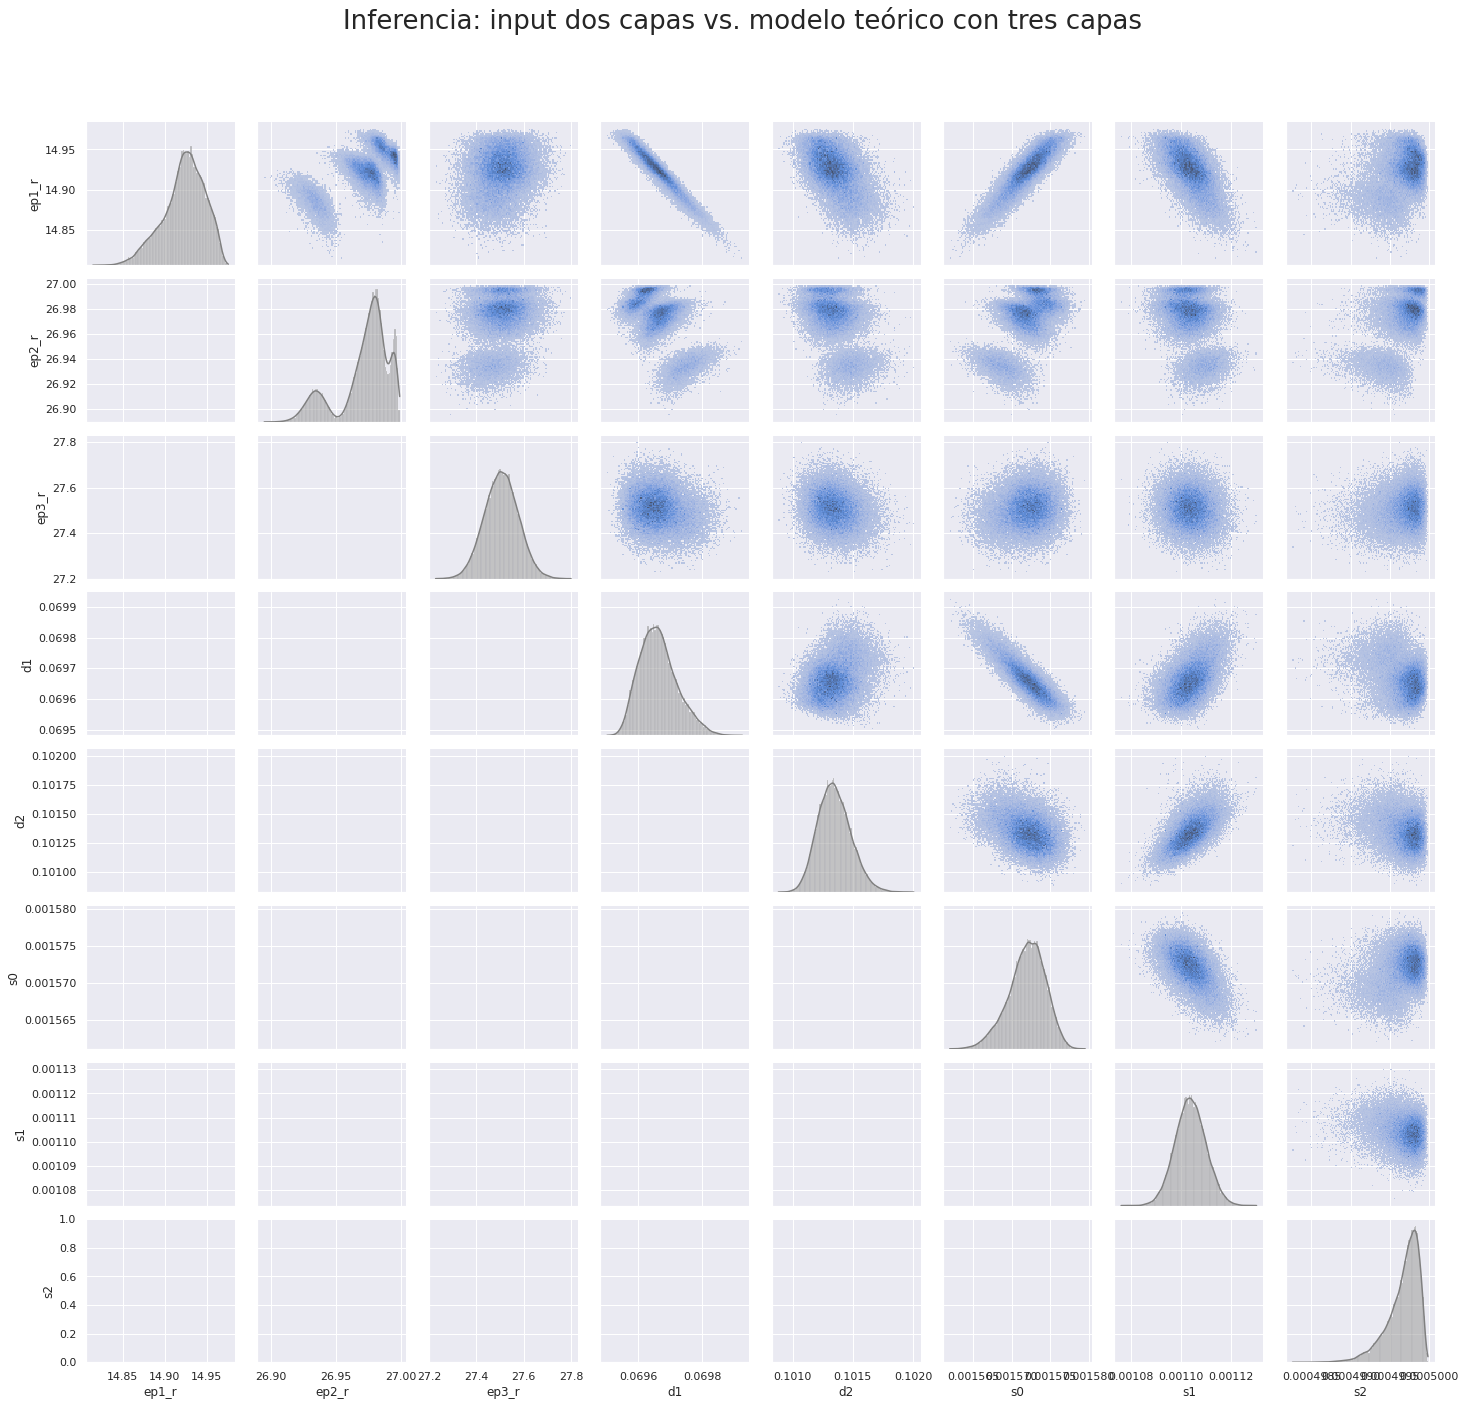

In [64]:
plotear_4 = np.stack((traza_sim_3L_rug['ep1_r'], traza_sim_3L_rug['ep2_r'], traza_sim_3L_rug['ep3_r'],traza_sim_3L_rug['d1'],
                     traza_sim_3L_rug['d2'],traza_sim_3L_rug['s0'],traza_sim_3L_rug['s1'],traza_sim_3L_rug['s2'])).T 
dfplotear_4 = pd.DataFrame(plotear_4, columns = name_list3)

g = sns.PairGrid(dfplotear_4)
g.map_upper(sns.histplot)
g.map_diag(sns.histplot, kde=True, color='.5')
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Inferencia: input dos capas vs. modelo teórico con tres capas', fontsize = 26)

# for j in range(2):
#     l1 = g.axes[j,j].axvline(np.real(inputs_par[j]), color='r', linestyle='solid', linewidth=0.75)
#     l2 = g.axes[j,j].axvline(Modas_4[j], color='k', linestyle='solid', linewidth=1.75)
#     l3 = g.axes[j,j].axvline(VMedios_4[j], color='g', linestyle='solid', linewidth=1.75)
    
# ind_corr = 0
# for j0 in range(2):
#     for j1 in range(2):
        
#         if(j1>j0):
#             g.axes[j0,j1].scatter(np.real(inputs_par[j1]), np.real(inputs_par[j0]), marker="8", c='r', s=50)
#             g.axes[j0,j1].scatter(Modas_4[j1], Modas_4[j0], marker="<", c='k', s=50)
#             g.axes[j0,j1].scatter(VMedios_4[j1], VMedios_4[j0], marker="v", c='g', s=50)
            
#             g.axes[j1,j0].annotate("r = {:.2f}".format(Correlaciones_4[ind_corr]),  xy=(VMedios_4[j0],VMedios_4[j1]), weight='bold', 
#                                  ha='center', va='center', size=18)
#             ind_corr = ind_corr + 1


# plt.legend([l1,l2,l3],['Inputs','Modas','V. Medios'],bbox_to_anchor=(-1, 5.65), shadow=True, ncol = 3)
plt.savefig('/home/tele/Desktop/sim4.jpg', dpi = 400)
# for j in range(len(name_list)):
#     print(name_list[j])
#     print('input :', np.real(inputs_par[j]))
#     print('output :', str(VMedios_2[j])+"\u00B1"+str(Std_2[j]))
#     print()
#     print('------------')
#     print()

### Acá uno podría esperar a que el esquema de inferencia se avive y:
- $d_1 = d_{in}$;
- tome el límite $d_2 \rightarrow \infty$;
- $\epsilon_1 = \epsilon_{1 in}$;
- $\epsilon_2 = \epsilon_{2 in}$;
- con el límite $d_2 \rightarrow \infty$ el valor de $\epsilon_3$ no importa.

Pero no, eso no es lo que ocurre. El algoritmo de inferencia es un esquema de estadística bayesiana que no sabe nada de física.
Por lo tanto, la casuistica importa: hay que saber algo de antemano para hacer un buen ajuste!
